### Multi-view Vs Single-view Methods for Clustering and Data Analysis

Here, we directly compare multi-view methods available within *mvlearn* to analagous single-view methods. Using the UCI Multiple Features Dataset, we first examine the dataset by viewing it after using dimensionality reduction techniques, then we perform unsupervised clustering and compare the results.

In [81]:
from mvlearn.datasets import load_UCImultifeature
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# If this is set to true, then the figure from the paper will be saved locally
save_figs = False
set_dpi = 1000

Load 6-view, 4-class data from the Multiple Features Dataset. We will be using the first 2 views for co-clustering, since mvlearn clustering currently only supports 2 views of data.

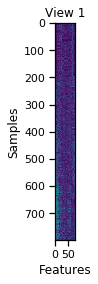

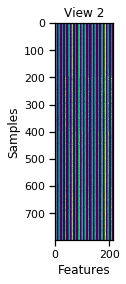

In [87]:
# Load 4-class, multi-view data
Xs, y = load_UCImultifeature(select_labeled=[0,1,2,3])

# Use the first 2 views for clustering
Xs_2 = Xs[:2]

# Plot heatmaps of the 2 views of data to be used for clustering
# For heatmap visualization, sort rows by true class
row_orders = np.argsort(y)
Xs_2_sorted = []
Xs_2_sorted.append(Xs_2[0].copy()[row_orders])
Xs_2_sorted.append(Xs_2[1].copy()[row_orders])
plt.imshow(Xs_2_sorted[0])
plt.title('View 1')
plt.ylabel('Samples')
plt.xlabel('Features')
if save_figs:
    plt.savefig('Paper_View1_heatmap.png', dpi=set_dpi)
plt.show()

plt.imshow(Xs_2_sorted[1])
plt.title('View 2')
plt.xlabel('Features')
if save_figs:
    plt.yticks([],[])
    plt.savefig('Paper_View2_heatmap.png', dpi=set_dpi)
plt.yticks(np.arange(0, 800, 100), np.arange(0, 800, 100))
plt.ylabel('Samples')
plt.show()

Define a function to rearrange the predicted labels so that the predicted class '0' corresponds better to the true class '0'. This is only used so that the colors generated by the labels in the prediction plots can be more easily compared to the true labels.

In [68]:
from sklearn.metrics import confusion_matrix

def rearrange_labels(y_true, y_pred):
    conf_mat = confusion_matrix(y_true, y_pred)
    maxes = np.argmax(conf_mat, axis=0)
    y_pred_new = np.zeros_like(y_pred)
    for i, new in enumerate(maxes):
        y_pred_new[y_pred==i] = new
    return y_pred_new

##### Comparing Dimensionality Reduction Techniques

As one might do with a new dataset, we first visualize the data in 2 dimensions. For multi-view data, rather than using PCA, we use Multi-view Multi-dimensional Scaling (MVMDS) available in the package to capture the common principal components across views. This is performed automatically within the quick_visualize function. From the unlabeled plot, it is clear that there may be 4 underlying clusters, so unsupervised clustering with 4 clusters may be a natural next step in analyzing this data.

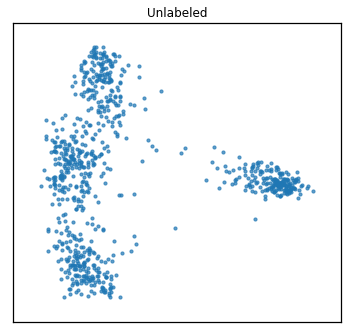

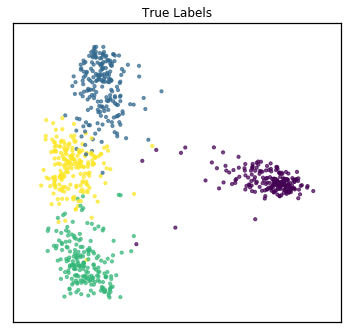

In [90]:
from mvlearn.plotting import quick_visualize

# Use all 6 views available to reduce the dimensionality, since MVMDS is not limited
sca_kwargs = {'alpha' : 0.7, 's' : 10}
if save_figs:
    fig = quick_visualize(Xs, show=False, title="Unlabeled", ax_ticks=False,
                          ax_labels=False, scatter_kwargs=sca_kwargs)
    fig = quick_visualize(Xs, labels=y, show=False, title="True Labels", ax_ticks=False,
                          ax_labels=False, scatter_kwargs=sca_kwargs)
    plt.savefig('Paper_multi_truelabels.png', dpi=set_dpi)
else:
    quick_visualize(Xs, title="Unlabeled", ax_ticks=False,
                    ax_labels=False, scatter_kwargs=sca_kwargs)
    quick_visualize(Xs, labels=y, title="True Labels", ax_ticks=False,
                    ax_labels=False, scatter_kwargs=sca_kwargs)

As a comparison, we concatenate the views and use PCA to reduce the dimensionality. From the unlabeled plot, it is much less clear how many underlying classes there are, so PCA was not as useful for visualizing the data if our goal was to determine underlying clusters.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


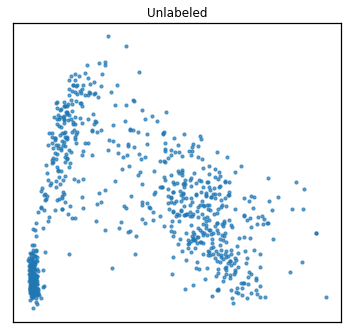

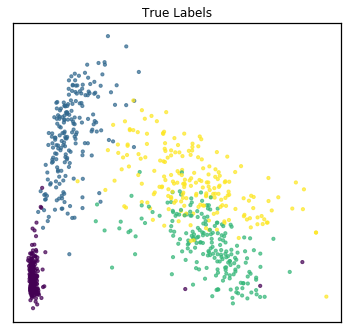

In [89]:
from sklearn.decomposition import PCA

# Concatenate views to get naive single view
X_viewing = np.hstack((Xs[i] for i in range(len(Xs))))

# Use PCA for dimensionality reduction on the naive single view
pca = PCA(n_components=2)
pca_X = pca.fit_transform(X_viewing)

plt.figure(figsize=(5, 5))
plt.scatter(pca_X[:,0], pca_X[:,1], **sca_kwargs)
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.title("Unlabeled")
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(pca_X[:,0], pca_X[:,1], c=y, **sca_kwargs)
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.title("True Labels")
if save_figs:
    plt.savefig('Paper_single_truelabels.png', dpi=set_dpi)
plt.show()

##### Comparing Clustering Techniques on the Full Feature Space

Now, assuming we are trying to group the samples into 4 clusters (as was much more obvious after using *mvlearn*'s dimensionality reduction viewing method), we compare multi-view clustering techniques to single-view counterparts. Specifically, we compare 2-view spectral clustering in *mvlearn* with single view spectral clustering from *scikit-learn*. For multi-view clustering, we use the first 2 full views of data (not the dimensionality-reduced data). For single-view comparison, we concatenate these 2 full views into a single larger view, similar to what we did before PCA.

Since we have the true class labels, we assess the clustering accuracy with a homogeneity score.

Multi-view homogeneity score: 0.932


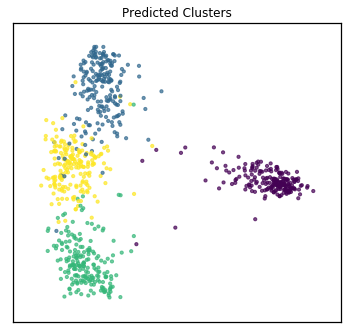

In [93]:
from mvlearn.cluster import MultiviewSpectralClustering

mv_clust = MultiviewSpectralClustering(n_clusters=4, affinity='nearest_neighbors')
mvlearn_cluster_labels = mv_clust.fit_predict(Xs_2)

# Test the accuracy of the clustering
from sklearn.metrics import homogeneity_score
mv_score = homogeneity_score(y, mvlearn_cluster_labels)
print('Multi-view homogeneity score: {0:.3f}'.format(mv_score))

# Use function defined at beginning of notebook to rearrange the labels
# for easier visual comparison to true labeled plot
mvlearn_cluster_labels = rearrange_labels(y, mvlearn_cluster_labels)

# Visualize the clusters in the 2-dimensional space
if save_figs:
    fig = quick_visualize(Xs, labels=mvlearn_cluster_labels, show=False, title="Predicted Clusters",
                          ax_ticks=False, ax_labels=False, scatter_kwargs=sca_kwargs)
    plt.savefig('Paper_multi_clustered.png', dpi=set_dpi)
else:
    quick_visualize(Xs, labels=mvlearn_cluster_labels, title="Predicted Clusters",
                    ax_ticks=False, ax_labels=False, scatter_kwargs=sca_kwargs)

To compare to single-view methods, we concatenate the two views we used for co-clustering into one data matrix, and then perform spectral clustering using the *scikit-learn* library.

Single-view homogeneity score: 0.903


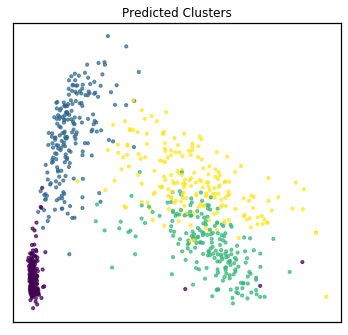

In [92]:
from sklearn.cluster import SpectralClustering

# Concatenate 2 views and cluster
X_clustering = np.hstack((Xs_2[0], Xs_2[1]))
clust = SpectralClustering(n_clusters=4, affinity='nearest_neighbors')
sklearn_cluster_labels = clust.fit_predict(X_clustering)

# Test the accuracy of the clustering
sk_score = homogeneity_score(y, sklearn_cluster_labels)
print('Single-view homogeneity score: {0:.3f}'.format(sk_score))

# Rearrange for easier visual comparison to true label plot
sklearn_cluster_labels = rearrange_labels(y, sklearn_cluster_labels)

# Use PCA for dimensionality reduction on the naive single view
pca = PCA(n_components=2)
pca_X = pca.fit_transform(X_viewing)

plt.figure(figsize=(5, 5))
plt.scatter(pca_X[:,0], pca_X[:,1], c=y, **sca_kwargs)
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.title("Predicted Clusters")
if save_figs:
    plt.savefig('Paper_single_clustered.png', dpi=set_dpi)
plt.show()

##### Code for paper figure

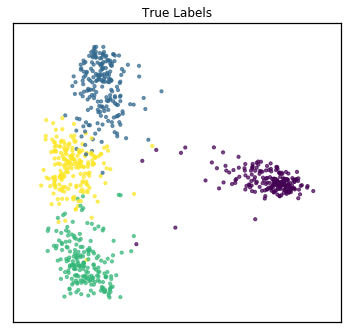

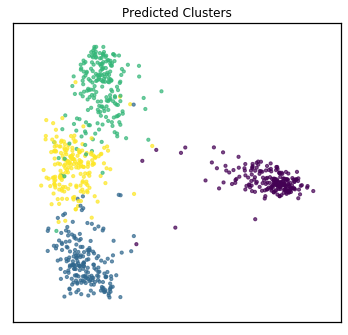

In [91]:
############ Using Multi-View Methods ############

from mvlearn.datasets import load_UCImultifeature
from mvlearn.plotting import quick_visualize
from mvlearn.cluster import MultiviewSpectralClustering
%matplotlib inline

# Load 4-class, multi-view data
Xs, y = load_UCImultifeature(select_labeled=[0,1,2,3])

# Use the first 2 views for clustering
Xs_2 = Xs[:2]

# Use Multi-view Multi-dimensional Scaling to Reduce 6 views to 2D
sca_kwargs = {'alpha' : 0.7, 's' : 10}
quick_visualize(Xs, labels=y, title="True Labels", ax_ticks=False,
                ax_labels=False, scatter_kwargs=sca_kwargs)

# Initialize multiview clustering object and estimate clusters
mv_clust = MultiviewSpectralClustering(n_clusters=4, affinity='nearest_neighbors')
mvlearn_cluster_labels = mv_clust.fit_predict(Xs_2)

# Plot predicted cluster labels over the 2D visualizaton
quick_visualize(Xs, labels=mvlearn_cluster_labels, title='Predicted Clusters',
                ax_ticks=False, ax_labels=False, scatter_kwargs=sca_kwargs)